# Configure font

In [1]:
# Configure Arial as the default font in all figures

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


arial_font_path = '/PATH/TO/ARIAL/FONT/arial.ttf'

fm.fontManager.addfont(arial_font_path)

plt.rcParams['font.family'] = 'Arial'

# Path to Zenodo files folder

In [2]:
path = '~/analyses/Cores/final_submission/zenodo/'

# Figure S19

## Panel A

In [3]:
# Correct indels in suppressor sequences

import ast
import pandas as pd

all_permissivity_seqs=pd.read_csv(path+'Fig6/Suppressor_library_allseqs.txt', sep='\t')

all_permissivity_seqs["full_variant"] = pd.Series(dtype="object")
all_permissivity_seqs["full_variant_len"] = pd.Series(dtype="object")
all_permissivity_seqs["deletions"] = pd.Series(dtype="object")
for index, row in all_permissivity_seqs.iterrows():
    if row.mutations.startswith('[')==True:
        mutations = ast.literal_eval(row.mutations)
        deletions=[]
        for mutation in mutations:
            if mutation[-1]=='-':
                deletions.append(mutation[1:-1])
        if len(deletions)>0:
            all_permissivity_seqs.at[index,'deletions']=','.join(deletions)
        full_variant=row.variant
        for deletion in deletions:
            full_variant = full_variant[:int(deletion)-1]+'-'+full_variant[int(deletion)-1:]
        all_permissivity_seqs.at[index,'full_variant']=full_variant
        all_permissivity_seqs.at[index,'full_variant_len']=len(full_variant)

In [4]:
import pandas as pd

permi_variants = pd.read_csv(path+'Fig6/FYN_suppressor_fitness_replicates.txt', sep='\t')


In [5]:
from seaborn import kdeplot
import numpy as np
import matplotlib.pyplot as plt

def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

permi_variants_scaled = permi_variants.copy()

arbitraryWT='FLFFVIV'

fig, ax = plt.subplots()

my_kde = kdeplot(data=permi_variants.loc[permi_variants['fitness']<-0.5], x='fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])
    ax.axvline(x[np.argmax(y)], ls='--')

permi_variants_scaled['fitness']=normalize(list(permi_variants_scaled['fitness']),{'actual': {'lower': mode, 'upper': permi_variants_scaled.loc[permi_variants_scaled['Nham_aa']==0]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
permi_variants_scaled['fitness1_uncorr']=normalize(list(permi_variants_scaled['fitness1_uncorr']),{'actual': {'lower': mode, 'upper': permi_variants_scaled.loc[permi_variants_scaled['Nham_aa']==0]['fitness1_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
permi_variants_scaled['fitness2_uncorr']=normalize(list(permi_variants_scaled['fitness2_uncorr']),{'actual': {'lower': mode, 'upper': permi_variants_scaled.loc[permi_variants_scaled['Nham_aa']==0]['fitness2_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
permi_variants_scaled['fitness3_uncorr']=normalize(list(permi_variants_scaled['fitness3_uncorr']),{'actual': {'lower': mode, 'upper': permi_variants_scaled.loc[permi_variants_scaled['Nham_aa']==0]['fitness3_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})


fig, ax = plt.subplots()

my_kde = kdeplot(data=permi_variants_scaled, x='fitness', ax=ax)

lines = my_kde.get_lines()

for line in lines:
    x, y = line.get_data()

plt.close()

In [6]:
WTs_bearing_natural_DTS_core_queries=pd.read_csv(path+'Fig6/Structural_homologs_carrying_detrimental_cores_in_FYN.txt',sep='\t')

permi_variants_scaled["other_natural_SH3s"] = pd.Series(dtype="object")
permi_variants_scaled["Pro_mutant"] = pd.Series(dtype="object")
for index, row in permi_variants_scaled.iterrows():
    if row.aa_seq in list(WTs_bearing_natural_DTS_core_queries['DSSP_boundaries']) or row.aa_seq in list(WTs_bearing_natural_DTS_core_queries['Pro_mutant_1']) or row.aa_seq in list(WTs_bearing_natural_DTS_core_queries['Pro_mutant_2']) or row.aa_seq in list(WTs_bearing_natural_DTS_core_queries['Pro_mutant_3']):
        permi_variants_scaled.at[index,'other_natural_SH3s']=True
        if row.aa_seq in list(WTs_bearing_natural_DTS_core_queries['DSSP_boundaries']):
            permi_variants_scaled.at[index,'Pro_mutant']=False
        else:
            permi_variants_scaled.at[index,'Pro_mutant']=True

other_natural_SH3s = permi_variants_scaled.loc[permi_variants_scaled['other_natural_SH3s']==True].copy()

In [7]:
# Find core and hamming distances

fyn_core_pos = [2,16,18,24,26,48,53]
fyn_wt_core = 'FLFFIIV'
fyn_permi_variants = permi_variants_scaled.loc[permi_variants_scaled['other_natural_SH3s']!=True].copy()
fyn_wt_seq = permi_variants_scaled.loc[permi_variants_scaled['Nham_aa']==0].iloc[0]['aa_seq']
fyn_permi_variants["full_variant"] = pd.Series(dtype="object")
fyn_permi_variants["core"] = pd.Series(dtype="object")
for index, row in fyn_permi_variants.iterrows():
    fyn_permi_variants.at[index,'full_variant']=all_permissivity_seqs.loc[all_permissivity_seqs['variant']==row.aa_seq].iloc[0]['full_variant']
    core=[]
    for i in fyn_core_pos:
        core.append(all_permissivity_seqs.loc[all_permissivity_seqs['variant']==row.aa_seq].iloc[0]['full_variant'][i])
    fyn_permi_variants.at[index,'core'] = ''.join(core)
    fyn_permi_variants.at[index, 'Nham_core'] = sum(1 for a,b in zip(core, fyn_wt_core) if a!=b)
    fyn_permi_variants.at[index, 'Nham_aa'] = sum(1 for a,b in zip(all_permissivity_seqs.loc[all_permissivity_seqs['variant']==row.aa_seq].iloc[0]['full_variant'], fyn_wt_seq) if a!=b)
    if len(row.aa_seq) != len(permi_variants.loc[permi_variants['Nham_aa']==0].iloc[0]['aa_seq']):
        fyn_permi_variants.at[index,'indel']=True
    fyn_permi_variants.at[index,'len']=len(row.aa_seq)

fyn_permi_variants["all_mutations"] = pd.Series(dtype="object")
for index, row in fyn_permi_variants.iterrows():
    mutations=[]
    iterator=1
    for wt, mut in zip(fyn_wt_seq, row.full_variant):
        if wt != mut:
            mutations.append(wt+str(iterator)+mut)
        iterator+=1
    fyn_permi_variants.at[index,'all_mutations']=','.join(mutations)

In [8]:
# Discern query types

detrimental_singles_FYN = pd.read_csv(path+'Fig6/Suppressor_lib_singles_queries.txt', sep='\t', index_col=0)
query_natural_DTS_cores = pd.read_csv(path+'Fig6/Suppressor_lib_transplant_queries.txt', sep='\t', index_col=0)

fyn_permi_variants["query_type"] = pd.Series(dtype="object")
for index, row in fyn_permi_variants.iterrows():
    if row.core in list(query_natural_DTS_cores.index):
        fyn_permi_variants.at[index,'query_type'] = 'Natural Core'
    else:
        fyn_permi_variants.at[index,'query_type'] = 'Single mutant'

In [9]:
single_query_data = fyn_permi_variants.loc[fyn_permi_variants['query_type']=='Single mutant'].copy()
fyn_wt_seq = permi_variants.loc[permi_variants['Nham_aa']==0].iloc[0]['aa_seq']
fyn_core_pos = [2,16,18,24,26,48,53]

for single_query in list(detrimental_singles_FYN['variant']):
    single_query_data[single_query] = False
    single_query_data[single_query + '_core_Nham'] = np.nan
    single_query_data[single_query + '_total_Nham'] = np.nan
    single_query_data[single_query + '_mutations'] = ""
    wt_aa = single_query[0]
    pos = int(single_query[1:-1])-1
    mut_aa = single_query[-1]
    query_seq = fyn_wt_seq[:pos]+mut_aa+fyn_wt_seq[pos+1:]
    query_core=[]
    for i in fyn_core_pos:
        query_core.append(query_seq[i])
    query_core=''.join(query_core)
    for index, row in single_query_data.iterrows():
        if row.aa_seq[pos] == mut_aa:
            single_query_data.at[index,single_query]=True
            single_query_data.at[index,single_query+'_core_Nham']= sum(1 for a,b in zip(row.core, query_core) if a!=b)
            single_query_data.at[index,single_query+'_total_Nham'] = sum(1 for a,b in zip(row.full_variant, query_seq) if a!=b)
            mutations=[]
            iterator=1
            for wt, mut in zip(query_seq, row.full_variant):
                if wt != mut:
                    mutations.append(wt+str(iterator)+mut)
                iterator+=1
            single_query_data.at[index,single_query+'_mutations']=','.join(mutations)
        else:
            single_query_data.at[index,single_query]=False

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)

    return newcmap

iterator_cmap = 0

In [11]:
from matplotlib.cm import ScalarMappable

protein_variants_scaled = single_query_data.sort_values('fitness', ascending=False).copy()
for core in list(detrimental_singles_FYN['variant']):
    for index, row in protein_variants_scaled.loc[protein_variants_scaled[core]==True].iterrows():
        protein_variants_scaled.at[index, 'delta_fitness_from_mutant'] = row.fitness - single_query_data.loc[single_query_data[core]==True].loc[single_query_data[core+'_total_Nham']==0].iloc[0]['fitness']
        #protein_variants_scaled.at[index, 'rounded_fitness_in_mutant_bgd'] = round(row.fitness,1)
        try:
            protein_variants_scaled.at[index, 'delta_fitness_from_fyn'] = single_query_data.loc[single_query_data['all_mutations']==row[core+'_mutations']].iloc[0]['fitness'] - single_query_data.loc[single_query_data['Nham_aa']==0].iloc[0]['fitness']
        except IndexError:
            continue
orig_cmap = plt.cm.coolwarm_r
norm = plt.Normalize(vmin=np.min(protein_variants_scaled['fitness']), vmax=np.max(protein_variants_scaled['fitness']))
iterator_cmap+=1
midpoint=(-0.5 - np.min(protein_variants_scaled['fitness']))/ (np.max(protein_variants_scaled['fitness']) - np.min(protein_variants_scaled['fitness']))
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=midpoint, name='shifted'+str(iterator_cmap))

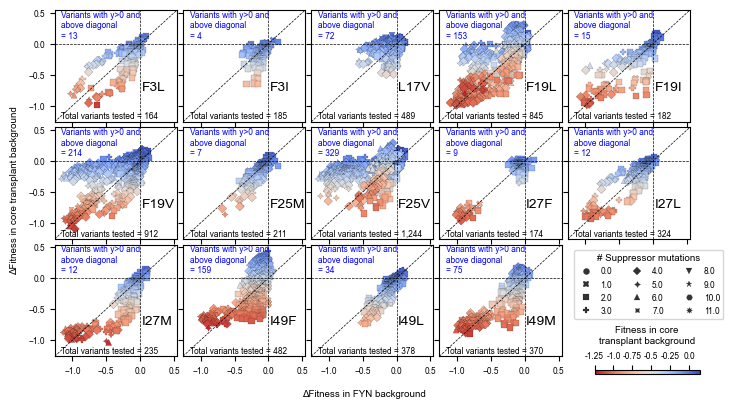

In [12]:
import seaborn as sns

symbols=['o','X','s','P','D',(4,1,0),'^',(4,1,45),'v','*','H',(8,1,0)]
markers={}
for mut_order, symbol in zip(np.arange(0,12,1).tolist(), symbols):
    markers[mut_order]=symbol

global_min = protein_variants_scaled['fitness'].min()
global_max = protein_variants_scaled['fitness'].max()
norm = plt.Normalize(vmin=global_min, vmax=global_max)

fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(2.5*14/5,1.5*8/3), sharex=True,sharey=True)

coliterator=0
rowiterator=0
for core in list(detrimental_singles_FYN['variant']):
    ax[rowiterator,coliterator].axline((0.1, 0.1), slope=1, linestyle = "dashed", color = 'black',lw=0.5)
    ax[rowiterator,coliterator].axvline(0,linestyle='dashed', color='black', lw=0.5)
    ax[rowiterator,coliterator].axhline(0,linestyle='dashed', color='black', lw=0.5)
    scat = sns.scatterplot(markers=markers, edgecolor='k', linewidth=0.1, s=20, ax=ax[rowiterator, coliterator], x='delta_fitness_from_fyn', y='delta_fitness_from_mutant', data=protein_variants_scaled.loc[protein_variants_scaled[core] == True], style=core + '_total_Nham', hue='fitness', palette=shifted_cmap, hue_norm=norm, rasterized=True)
    #ax[rowiterator,coliterator].set_title(core, fontsize=7)
    ax[rowiterator,coliterator].set_ylim(np.min(protein_variants_scaled['delta_fitness_from_fyn'])-0.1,np.max(protein_variants_scaled['delta_fitness_from_mutant'])+0.1)
    ax[rowiterator,coliterator].set_xlim(np.min(protein_variants_scaled['delta_fitness_from_fyn'])-0.1,np.max(protein_variants_scaled['delta_fitness_from_mutant'])+0.1)
    ax[rowiterator,coliterator].tick_params(axis='x', labelsize=6)
    ax[rowiterator,coliterator].tick_params(axis='y', labelsize=6)
    ax[rowiterator,coliterator].get_legend().remove()
    ax[rowiterator,coliterator].set_xlabel('')
    ax[rowiterator,coliterator].set_ylabel('')
    ax[rowiterator,coliterator].annotate(core, (0.02,-0.75), fontsize=10)
    ax[rowiterator,coliterator].annotate('Total variants tested = '+f"{len(protein_variants_scaled.loc[protein_variants_scaled[core]==True]):,}", (np.min(protein_variants_scaled['delta_fitness_from_fyn']),np.min(protein_variants_scaled['delta_fitness_from_fyn'])-0.05), fontsize=6)
    ax[rowiterator,coliterator].annotate('Variants with y>0 and\nabove diagonal\n= '+f"{len(protein_variants_scaled.loc[protein_variants_scaled[core]==True].loc[protein_variants_scaled['delta_fitness_from_fyn']<protein_variants_scaled['delta_fitness_from_mutant']].loc[protein_variants_scaled['delta_fitness_from_mutant']>0]):,}", (np.min(protein_variants_scaled['delta_fitness_from_fyn']),np.max(protein_variants_scaled['delta_fitness_from_mutant'])-0.35), fontsize=6, color='blue')
    ax[rowiterator,coliterator].set_rasterization_zorder(0)
    coliterator+=1
    if coliterator >4:
        coliterator=0
        rowiterator+=1
handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
handles, labels = [sum(lol, []) for lol in zip(*handles_labels)]
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
actual_labels = [item for item in label_list if item.replace('.', '', 1).isdigit() and float(item).is_integer() and item != '0.00']
actual_labels_indices = [idx for idx, item in enumerate(label_list) if item.replace('.', '', 1).isdigit() and float(item).is_integer() and item != '0.00']
actual_handles = [handle_list[i] for i in actual_labels_indices]
legend=fig.legend(actual_handles, actual_labels, ncols=3, title='# Suppressor mutations', bbox_to_anchor=[1.02,0.36], fontsize=6)
legend.get_title().set_fontsize('7')
fig.text(0.5, -0.015, 'ΔFitness in FYN background', ha='center', fontsize=7)
fig.text(-0.005, 0.5, 'ΔFitness in core transplant background', va='center', rotation='vertical', fontsize=7)
fig.delaxes(ax[-1,-1])
fig.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)
cax=fig.add_axes([0.83,0.04,0.15,0.01])
cb=scat.figure.colorbar(plt.cm.ScalarMappable(cmap=shifted_cmap, norm=norm), cax=cax, location='top')
cax.set_xticks(np.arange(-1.25,0.25,0.25), np.arange(-1.25,0.25,0.25), fontsize=6)
cb.outline.set_visible(True)
cb.ax.set_title('Fitness in core\ntransplant background', fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Permi_single_queries_delta_fitness_allmutants.svg', dpi=300, transparent=False, bbox_inches='tight')

## Panel B

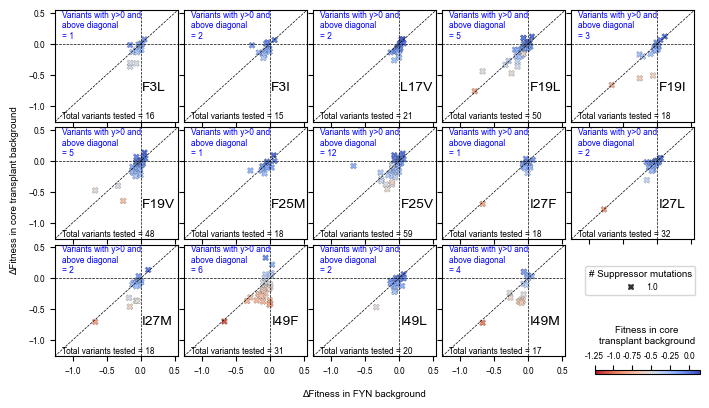

In [13]:
symbols=['o','X','s','P','D',(4,1,0),'^',(4,1,45),'v','*','H',(8,1,0)]
markers={}
for mut_order, symbol in zip(np.arange(0,12,1).tolist(), symbols):
    markers[mut_order]=symbol

global_min = protein_variants_scaled['fitness'].min()
global_max = protein_variants_scaled['fitness'].max()
norm = plt.Normalize(vmin=global_min, vmax=global_max)

fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(2.5*14/5,1.5*8/3), sharex=True,sharey=True)

coliterator=0
rowiterator=0
for core in list(detrimental_singles_FYN['variant']):
    ax[rowiterator,coliterator].axline((0.1, 0.1), slope=1, linestyle = "dashed", color = 'black',lw=0.5)
    ax[rowiterator,coliterator].axvline(0,linestyle='dashed', color='black', lw=0.5)
    ax[rowiterator,coliterator].axhline(0,linestyle='dashed', color='black', lw=0.5)
    scat = sns.scatterplot(markers=markers, edgecolor='k', linewidth=0.1, s=20, ax=ax[rowiterator, coliterator], x='delta_fitness_from_fyn', y='delta_fitness_from_mutant', data=protein_variants_scaled.loc[protein_variants_scaled[core] == True].loc[protein_variants_scaled[core+'_total_Nham']==1], style=core + '_total_Nham', hue='fitness', palette=shifted_cmap, hue_norm=norm, rasterized=True)
    #ax[rowiterator,coliterator].set_title(core, fontsize=7)
    ax[rowiterator,coliterator].set_ylim(np.min(protein_variants_scaled['delta_fitness_from_fyn'])-0.1,np.max(protein_variants_scaled['delta_fitness_from_mutant'])+0.1)
    ax[rowiterator,coliterator].set_xlim(np.min(protein_variants_scaled['delta_fitness_from_fyn'])-0.1,np.max(protein_variants_scaled['delta_fitness_from_mutant'])+0.1)
    ax[rowiterator,coliterator].tick_params(axis='x', labelsize=6)
    ax[rowiterator,coliterator].tick_params(axis='y', labelsize=6)
    ax[rowiterator,coliterator].get_legend().remove()
    ax[rowiterator,coliterator].set_xlabel('')
    ax[rowiterator,coliterator].set_ylabel('')
    ax[rowiterator,coliterator].annotate(core, (0.02,-0.75), fontsize=10)
    ax[rowiterator,coliterator].annotate('Total variants tested = '+f"{len(protein_variants_scaled.loc[protein_variants_scaled[core]==True].loc[protein_variants_scaled[core+'_total_Nham']==1]):,}", (np.min(protein_variants_scaled['delta_fitness_from_fyn']),np.min(protein_variants_scaled['delta_fitness_from_fyn'])-0.05), fontsize=6)
    ax[rowiterator,coliterator].annotate('Variants with y>0 and\nabove diagonal\n= '+f"{len(protein_variants_scaled.loc[protein_variants_scaled[core]==True].loc[protein_variants_scaled[core+'_total_Nham']==1].loc[protein_variants_scaled['delta_fitness_from_fyn']<protein_variants_scaled['delta_fitness_from_mutant']].loc[protein_variants_scaled['delta_fitness_from_mutant']>0]):,}", (np.min(protein_variants_scaled['delta_fitness_from_fyn']),np.max(protein_variants_scaled['delta_fitness_from_mutant'])-0.35), fontsize=6, color='blue')
    ax[rowiterator,coliterator].set_rasterization_zorder(0)
    coliterator+=1
    if coliterator >4:
        coliterator=0
        rowiterator+=1
handles_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
handles, labels = [sum(lol, []) for lol in zip(*handles_labels)]
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
actual_labels = [item for item in label_list if item.replace('.', '', 1).isdigit() and float(item).is_integer() and item != '0.0' and item != '0.00']
actual_labels_indices = [idx for idx, item in enumerate(label_list) if item.replace('.', '', 1).isdigit() and float(item).is_integer() and item != '0.0' and item != '0.00']
actual_handles = [handle_list[i] for i in actual_labels_indices]
legend=fig.legend(actual_handles, actual_labels, ncols=3, title='# Suppressor mutations', bbox_to_anchor=[0.98,0.32], fontsize=6)
#legend=fig.legend(handle_list, label_list, ncols=3, title='# Suppressor mutations', bbox_to_anchor=[0.98,0.32], fontsize=6)
legend.get_title().set_fontsize('7')
fig.text(0.5, -0.015, 'ΔFitness in FYN background', ha='center', fontsize=7)
fig.text(-0.005, 0.5, 'ΔFitness in core transplant background', va='center', rotation='vertical', fontsize=7)
fig.delaxes(ax[-1,-1])
fig.tight_layout()
plt.subplots_adjust(hspace=0.05, wspace=0.05)
cax=fig.add_axes([0.83,0.04,0.15,0.01])
cb=scat.figure.colorbar(plt.cm.ScalarMappable(cmap=shifted_cmap, norm=norm), cax=cax, location='top')
cax.set_xticks(np.arange(-1.25,0.25,0.25), np.arange(-1.25,0.25,0.25), fontsize=6)
cb.outline.set_visible(True)
cb.ax.set_title('Fitness in core\ntransplant background', fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Permi_single_queries_delta_fitness_only1stordermutants.svg', dpi=300, transparent=False, bbox_inches='tight')

## Panel C

In [14]:
top_rescuing_singles={}

for core in list(detrimental_singles_FYN['variant']):

    top_rescuing_singles[core]=protein_variants_scaled.loc[protein_variants_scaled[core]==True].loc[protein_variants_scaled['delta_fitness_from_fyn']<protein_variants_scaled['delta_fitness_from_mutant']].loc[protein_variants_scaled['delta_fitness_from_mutant']>0].loc[protein_variants_scaled[core+'_total_Nham']==1].sort_values('fitness', ascending=False).iloc[0][core+'_mutations']

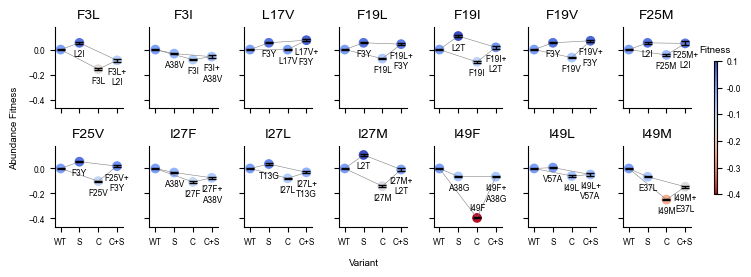

In [15]:
import networkx as nx

ylim_top = 0
ylim_bottom = 0
for core_query, rescue_single in top_rescuing_singles.items():
    combined_mutations = sorted([core_query ]+rescue_single.split(','), key=lambda x: (int(x[1:-1]), x[-1]) )
    mutations = ['',rescue_single,core_query,','.join(combined_mutations)]
    for mutation in mutations:
        if fyn_permi_variants.loc[fyn_permi_variants['all_mutations']==mutation].iloc[0]['fitness'] > ylim_top:
            ylim_top = fyn_permi_variants.loc[fyn_permi_variants['all_mutations']==mutation].iloc[0]['fitness']
        if fyn_permi_variants.loc[fyn_permi_variants['all_mutations']==mutation].iloc[0]['fitness'] < ylim_bottom:
            ylim_bottom = fyn_permi_variants.loc[fyn_permi_variants['all_mutations']==mutation].iloc[0]['fitness']
            
orig_cmap = plt.cm.coolwarm_r
norm = plt.Normalize(vmin=round(ylim_bottom,1), vmax=round(ylim_top,1))
iterator_cmap+=1
midpoint=(-0.5 - ylim_bottom/ (ylim_top - ylim_bottom))
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=midpoint, name='shifted'+str(iterator_cmap))

fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(2.5*14/5,1*8/3), sharex=True,sharey=True)
coliterator=0
rowiterator=0
for core_query, rescue_single in top_rescuing_singles.items():
    rescue_single_scatter_df=pd.DataFrame()
    variant_types = ['WT', 'S', 'C', 'C+S']
    combined_mutations = sorted([core_query] +rescue_single.split(','), key=lambda x: (int(x[1:-1]), x[-1]) )
    mutations = ['',rescue_single,core_query,','.join(combined_mutations)]
    rescue_single_scatter_df["variant_type"] = pd.Series(dtype="object")
    rescue_single_scatter_df["mutation"] = pd.Series(dtype="object")
    rescue_single_scatter_df["fitness"] = pd.Series(dtype=float)
    rescue_single_scatter_df["sigma"] = pd.Series(dtype=float)
    rescue_single_scatter_df["full_variant"] = pd.Series(dtype="object")
    rescue_single_scatter_df["label"] = pd.Series(dtype="object")
    for variant_type, mutation in zip(variant_types, enumerate(mutations)):
        rescue_single_scatter_df.at[mutation[0], 'variant_type'] = variant_type
        rescue_single_scatter_df.at[mutation[0], 'mutation'] = mutation[1]
        rescue_single_scatter_df.at[mutation[0], 'fitness'] = fyn_permi_variants.loc[fyn_permi_variants['all_mutations']==mutation[1]].iloc[0]['fitness']
        rescue_single_scatter_df.at[mutation[0], 'sigma'] = fyn_permi_variants.loc[fyn_permi_variants['all_mutations']==mutation[1]].iloc[0]['sigma']
        rescue_single_scatter_df.at[mutation[0], 'full_variant'] = fyn_permi_variants.loc[fyn_permi_variants['all_mutations']==mutation[1]].iloc[0]['full_variant']
        
        if variant_type == 'WT':
            rescue_single_scatter_df.at[mutation[0], 'label'] = ''
        elif variant_type == 'S':
            permi_mutations = mutation[1]
            rescue_single_scatter_df.at[mutation[0], 'label'] = mutation[1]
        elif variant_type == 'C':
            rescue_single_scatter_df.at[mutation[0], 'label'] = core_query
        elif variant_type == 'C+S':
            rescue_single_scatter_df.at[mutation[0], 'label'] = core_query+'+\n'+permi_mutations
        
    dod={'WT':['S', 'C'],
         'S': ['WT','C+S'],
         'C': ['WT','C+S']}
        
    G = nx.from_dict_of_lists(dod)
    
    pos={}
    for index, row in rescue_single_scatter_df.iterrows():
        pos[row.variant_type] = (row.name, row.fitness)
        
    ax[rowiterator,coliterator].errorbar(data=rescue_single_scatter_df,x='variant_type',y='fitness',yerr='sigma', linewidth=0, ms=0, elinewidth=1, capsize=3, color='k')
    ax[rowiterator,coliterator].scatter(data=rescue_single_scatter_df,x='variant_type',y='fitness',c = orig_cmap(norm(rescue_single_scatter_df['fitness'])))
    nx.draw_networkx(G, pos=pos, with_labels=False, node_size=0, edge_color='gray', width=0.4, ax=ax[rowiterator,coliterator])
    ax[rowiterator,coliterator].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax[rowiterator,coliterator].set_title(core_query,fontsize=10)
    ax[rowiterator,coliterator].tick_params(axis='x', labelsize=6)
    ax[rowiterator,coliterator].tick_params(axis='y', labelsize=6)
    ax[rowiterator,coliterator].set_ylim(ylim_bottom-0.075,ylim_top+0.075)
    ax[rowiterator,coliterator].spines[['right', 'top']].set_visible(False)
    
    for index, row in rescue_single_scatter_df.iterrows():
        if row.fitness > -0.35:
            ax[rowiterator,coliterator].annotate(row.label, (row.variant_type, row.fitness-0.055), horizontalalignment='center', verticalalignment='top', fontsize=6)
        else:
            ax[rowiterator,coliterator].annotate(row.label, (row.variant_type, row.fitness+0.12), horizontalalignment='center', verticalalignment='top', fontsize=6)
    
    
    if coliterator != 0:
        ax[rowiterator,coliterator].yaxis.set_tick_params(labelleft=False)
    if rowiterator != 1:
        ax[rowiterator,coliterator].xaxis.set_tick_params(labelbottom=False)
    
    coliterator+=1
    if coliterator >6:
        coliterator=0
        rowiterator+=1

fig.text(0.5, -0.015, 'Variant', ha='center', fontsize=7)
fig.text(-0.005, 0.5, 'Abundance Fitness', va='center', rotation='vertical', fontsize=7)
#fig.delaxes(ax[-1,-1])
fig.tight_layout()

cax=fig.add_axes([1,0.25,0.005,0.5])
cb=fig.figure.colorbar(plt.cm.ScalarMappable(cmap=orig_cmap, norm=norm), cax=cax, orientation='vertical')
cb.outline.set_visible(True)
cb.ax.set_title('Fitness', fontsize=7)
#cb.ax.set_yticks(cb.ax.get_yticks(),[str(round(i,1)) for i in cb.ax.get_yticks()],fontsize=6)
cb.ax.set_yticks(np.arange(-0.4,0.15,0.1),[str(round(i,1)) for i in np.arange(-0.4,0.15,0.1)],fontsize=6)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Fitness_recovery_single_queries_best_single.svg', dpi=300, bbox_inches='tight')